In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
# from torchvision.models import efficientnet_b3
from torchvision.models import EfficientNet_B3_Weights
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import torch.backends.cudnn as cudnn
from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import os

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

# 1. Load Data
# Data Directory in TALC
data_dir = '/work/TALC/enel645_2025w/garbage_data/'

print("Data loaded successfully.")

#2. Pre-process Data
data_transforms = {
    'CVPR_2024_dataset_Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'CVPR_2024_dataset_Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'CVPR_2024_dataset_Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 3. Setup with Train, Validation, Test Split
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['CVPR_2024_dataset_Train', 'CVPR_2024_dataset_Val', 'CVPR_2024_dataset_Test']}

# Creating Dataloaders for the datasets
train_loader = torch.utils.data.DataLoader(image_datasets['CVPR_2024_dataset_Train'], batch_size=16, shuffle=True,pin_memory=True)
val_loader = torch.utils.data.DataLoader(image_datasets['CVPR_2024_dataset_Val'], batch_size=16, shuffle=False,pin_memory=True)
test_loader = torch.utils.data.DataLoader(image_datasets['CVPR_2024_dataset_Test'], batch_size=16, shuffle=False,pin_memory=True)


dataset_sizes = {x: len(image_datasets[x]) for x in ['CVPR_2024_dataset_Train', 'CVPR_2024_dataset_Val', 'CVPR_2024_dataset_Test']}
class_names = image_datasets['CVPR_2024_dataset_Train'].classes

# Printing dataset info
print("Train set:", dataset_sizes['CVPR_2024_dataset_Train'])
print("Val set:", dataset_sizes['CVPR_2024_dataset_Val'])
print("Test set:", dataset_sizes['CVPR_2024_dataset_Test'])
print("Class names:", class_names)

# Creating iterators and batch for training data
train_iter = iter(train_loader)
train_batch = next(train_iter)
print(f"Batch size for training data: {train_batch[0].size()}")
print(f"Labels size for training data: {train_batch[1].size()}")

# Denormalizing the image before displaying
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Convert tensor to NumPy
img = train_batch[0][1].cpu().numpy().transpose(1, 2, 0)
img = img * std + mean  # Undo normalization
img = np.clip(img, 0, 1)  # Ensure valid range

plt.figure()
plt.imshow(img)
plt.show(block=False)
time.sleep(5)
plt.close()

# 4. Transfer Learning and Convolution
class GarbageClassifier(nn.Module):
    def __init__(self, num_class, input_shape, transfer=False):
        super().__init__()  # Correct the super() call

        # Initializing the parameters
        self.num_class = num_class
        self.input_shape = input_shape
        self.transfer = transfer

        # Initializing the feature Extractor (EfficientNetB3)
        self.feature_extract = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)

        # Transfer learning
        if self.transfer:
            # Freezing layers
            self.feature_extract.eval()
            # Freezing Parameters
            for param in self.feature_extract.parameters():
                param.requires_grad = False

        # Number of features for classifier input
        n_features = self.get_conv_output(self.input_shape)

        # Classifier model to classify features into each class (fully connected layer)
        self.classifier = nn.Linear(n_features, num_class)

    def get_conv_output(self, shape):
        batch_size = 1
        temp_in = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feature = self.feature_extract(temp_in)
        n_size = output_feature.data.view(batch_size, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.feature_extract(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


print("GarbageClassifier class created.")

net = GarbageClassifier(4, (3,224,224), True)
net.to(device)

print("Model initialized and moved to device.")

# 5. Loss and Metrics, Experiment Tracking
# Fine Tuned Model for training
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    PATH = 'bestgarbage_net1.pth'
    best_loss = 1e+20

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
        scheduler.step()

        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
            print(f'validation loss: {val_loss / i:.3f}')

            if val_loss < best_loss:

                print("Saving model")
                torch.save(model.state_dict(), PATH)
                best_loss = val_loss

    print('Finished Training')
    return model

# 6. Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# 7. Training the garbage model
net = train_model(net, criterion, optimizer, scheduler,
                       num_epochs=2)

print("Training complete.")

# Load the best model to be used in the test set
net = GarbageClassifier(4, (3,224,224), True)
net.load_state_dict(torch.load('bestgarbage_net1.pth'))
net.to(device)

print("Best model loaded.")

# 8. Testing the garbage model
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 9. Final Accuracy score, Class accuracy score and confusion matrix
print(f'Accuracy on the test images: {100 * correct / total} %')

# Class Accuracy Variables
class_correct = list(0. for _ in range(len(class_names)))
class_total = list(0. for _ in range(len(class_names)))

# Confusion matrix
conf_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)
net.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

# Print class accuracy
for i in range(len(class_names)):
    print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

### Code Output running on cluster ###

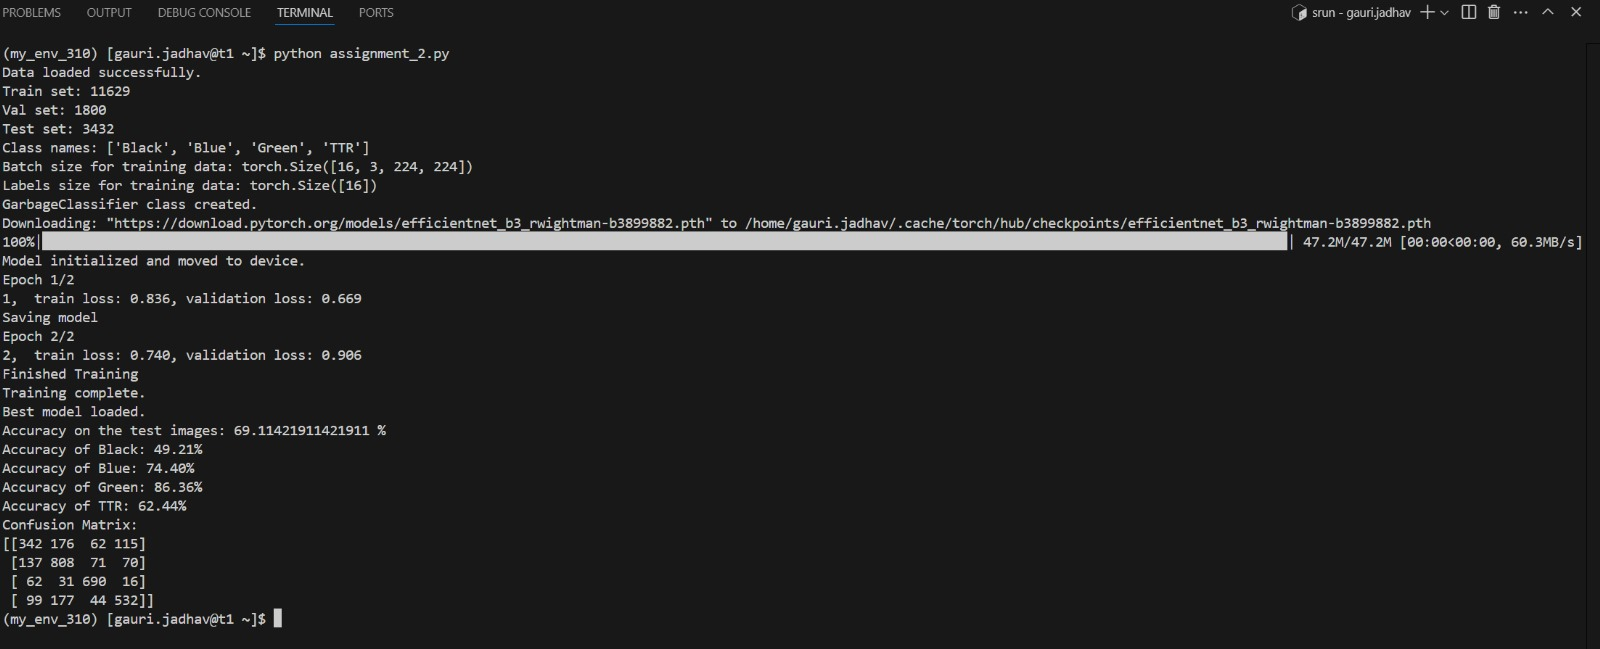